In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport cam
%aimport Net
import Net
import random
import Models 
from train_test_validat import *
import  ecg_get_data 
import ECGplot
import cam 

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

test_npy_path =  './data/test/' #路径
xml_path = './xml/xml/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
DEVICE = 'cpu'

In [3]:
test_Dataset = ecg_get_data.ECG_Dataset(test_npy_path,EcgChannles_num,EcgLength_num)

npys:{%d} 100


In [4]:
testmodel = (Net.channels_branch_CNN(True)).to(DEVICE)
testmodel.load_state_dict(torch.load("./model/20221015_101923/parameter_EarlyStoping_0.pt"))

<All keys matched successfully>

In [5]:
TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=TEST_BATCH_SIZE)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

loss = 0.4628967046737671 acc = 0.86
f1_macro = 0.8585858585858586


In [ ]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)


# 存放梯度和特征图
# testmodel.layers2_list[0].register_forward_hook(farward_hook)	#正向传播
# testmodel.layers2_list[0].register_full_backward_hook(backward_hook)#反向传播
testmodel.conv0.register_forward_hook(farward_hook)	#正向传播
testmodel.conv0.register_full_backward_hook(backward_hook)#反向传播


itme = 46
inputs,labels = test_Dataset.__getitem__(itme)

labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1)     # 求概率最大值对应的标签
print("labels: {}".format(labels))
print("predict: {}".format(pred))
loss = testmodel.last_out[0,pred]      # 网络对应于pred的类别的输出即为loss
# loss = (testmodel.last_out)[0,pred]
loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用

In [ ]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()

In [ ]:
print((testmodel.fc.weight).size()) 

In [ ]:
grad_block[0][0].shape

In [ ]:
fmap_block[0][0].shape

In [ ]:

grad_cam_pp_vlue = cam.caculate_grad_cam_pp_vlue(fmap,gradmap)
grad_cam_vlue = cam.caculate_grad_cam_vlue(fmap,gradmap)
layer_cam_vlue = cam.caculate_layer_cam_vlue(fmap,gradmap)


In [ ]:
fc_weight_0 = (testmodel.fc.weight[1,0:384].detach().numpy())
fc_weight_0 = np.expand_dims(fc_weight_0,axis=1)
cam_value = cam.caculate_cam_vlue(fmap,fc_weight_0)

In [ ]:
x = np.arange(0,5000)
y = cam_value
y1 = grad_cam_vlue
y2 = grad_cam_pp_vlue
y3 = layer_cam_vlue
fig, ax = plt.subplots(figsize=(16,9))

l1, = ax.plot(x,y,label='CAM')
l2, =ax.plot(x,y1,label='Grad CAM')
l3, =ax.plot(x,y2,label='Grad CAM++')
l4, =ax.plot(x,y3,label='Layer')

plt.legend([l1,l2,l3,l4],['CAM','Grad CAM','Grad CAM++','Layer'])


In [ ]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,sharey=True,figsize=(23,26), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = cam_value
    #plot_y = x[1,i,:]*(4.88)
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])

In [40]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)


# 存放梯度和特征图
# testmodel.layers2_list[0].register_forward_hook(farward_hook)	#正向传播
# testmodel.layers2_list[0].register_full_backward_hook(backward_hook)#反向传播
testmodel.conv0.register_forward_hook(farward_hook)	#正向传播
testmodel.conv0.register_full_backward_hook(backward_hook)#反向传播


itme = 18
inputs,labels = test_Dataset.__getitem__(itme)

labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1)     # 求概率最大值对应的标签
print("labels: {}".format(labels))
print("predict: {}".format(pred))
loss = testmodel.last_out[0,pred]      # 网络对应于pred的类别的输出即为loss
# loss = (testmodel.last_out)[0,pred]
loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用

labels: tensor([1])
predict: tensor([1])


In [41]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)

In [42]:
layer2d_vlue.shape

(12, 5000)

In [49]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    ax.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    ax.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

In [50]:
channel_cam = layer2d_vlue.sum(axis=1)
timestep_cam = layer2d_vlue.sum(axis=0)

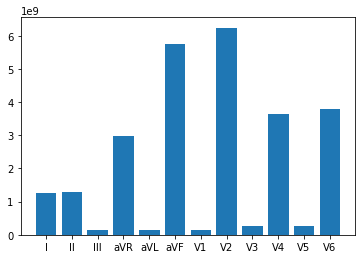

In [51]:
fig, ax = plt.subplots()
ax.bar(lead_index, channel_cam)
plt.show()

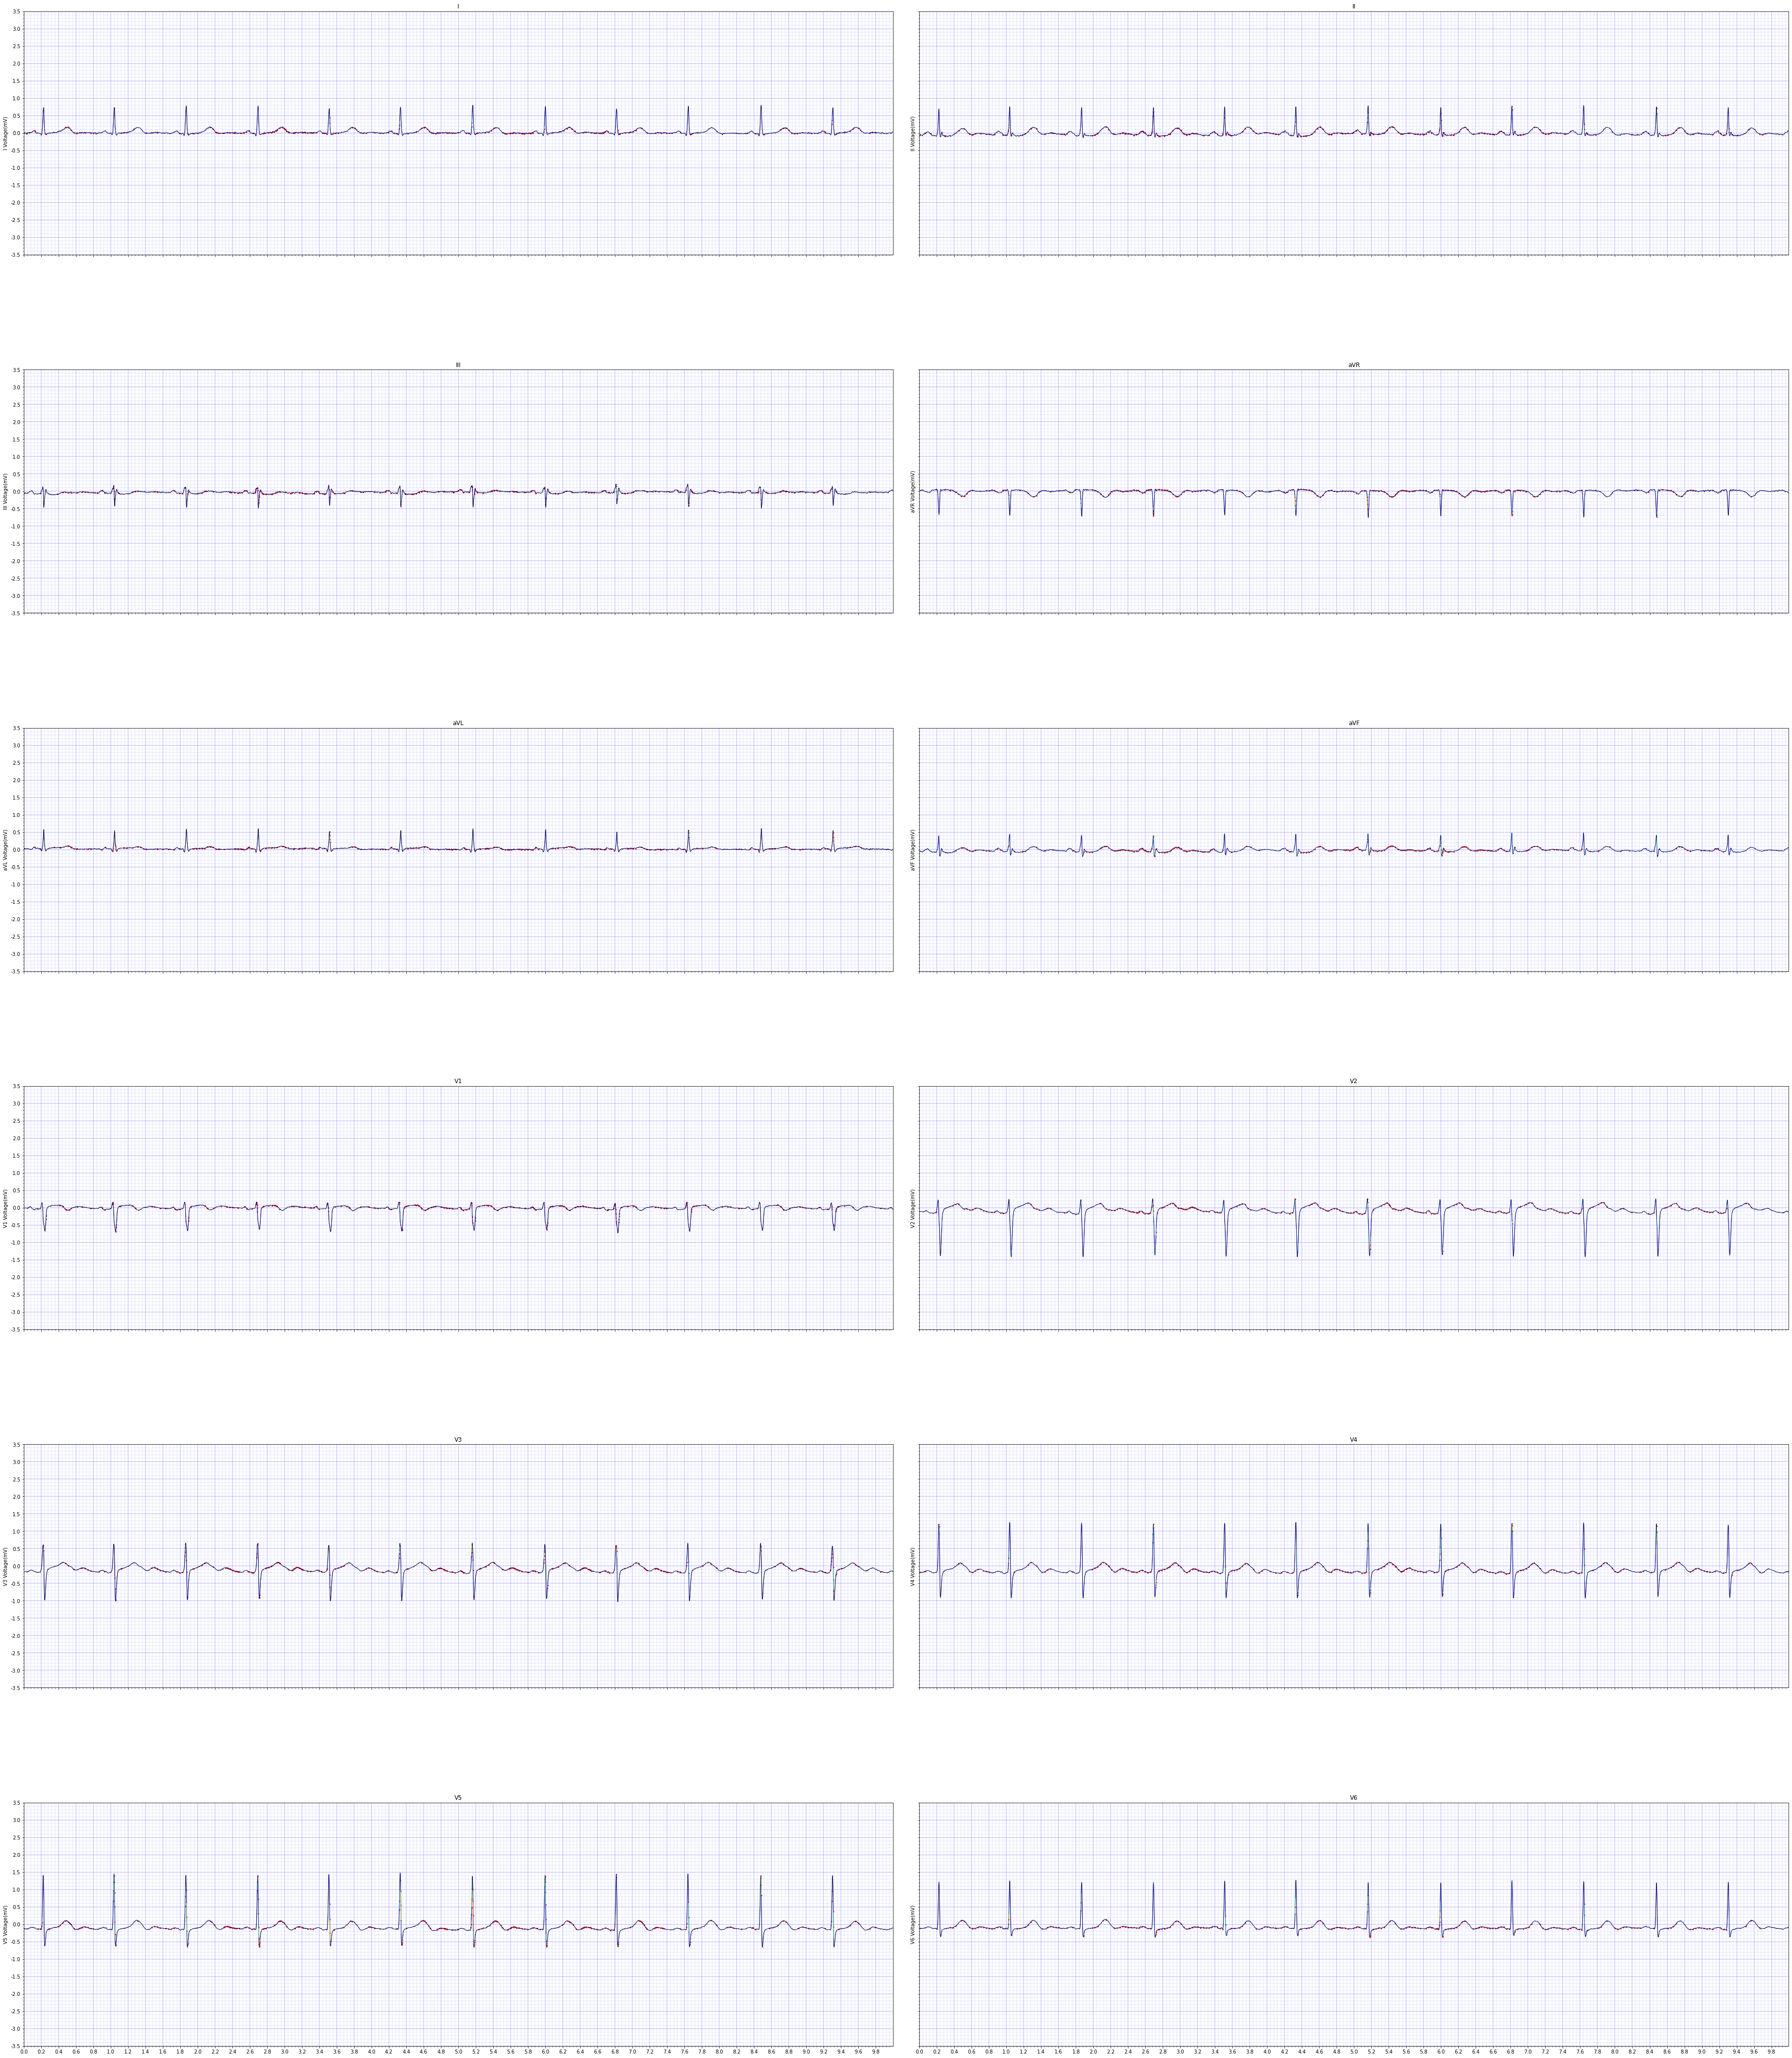

In [54]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = layer2d_vlue[i]
    #plot_y = x[1,i,:]*(4.88)
    
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)